In [7]:
%reset -f
import os
import sys
import pathlib
# import argparse

sys.path.append('/home/psimmerl/mds_analysis')

import math
import numpy as np
import numba as nb
from math import ceil, floor

import pickle

# from src.helper_functions import alert, Table
# from src.histo_utilities import std_color_list as SCL

from src import CMS_lumi, tdrstyle
root_style = tdrstyle.setTDRStyle()

import ROOT as rt
from ROOT import RDataFrame
# from ROOT import TNtuple, TTree, TBranch, RDataFrame
from ROOT import TCanvas, TLatex, TLegend, TLine, TBox
from ROOT import TH1D, TH2D, TGraph, TGraphErrors, TGraphAsymmErrors

from src.helper_functions import alert, Table, weight_calc

# **************************** #
OUT_DIR = 'reports/weekly/2024-03-27'
LOCAL_OUT_DIR = '/home/psimmerl/mds_analysis'  # os.getcwd()

DATA_VERSION = '6'
LUMI = 23.02 * 1000
PI = rt.TMath.Pi()

LOCAL_DATA_DIR = '/home/psimmerl/mds_analysis/data'  # os.getcwd() + '/data/raw'
DATA_DIR = LOCAL_DATA_DIR#'TIER2' if 'caltech' in os.uname()[1] else 'LOCAL'
OUT_DIR = f'{LOCAL_OUT_DIR}/{OUT_DIR}'

pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

ROOT_ERROR_LEVEL = 1001  # rt.kInfo + 1
rt.gErrorIgnoreLevel = ROOT_ERROR_LEVEL

SCL = [1, 2, 4, 8, 6, 28, 43, 7, 25, 36, 30, 40, 42, 49, 46, 38, 32, 800, 600, 900, 870, 840]
LUMI = 1.1328524540090597e-06 * 23.02 * 1000  # ???
C, D = "cscRechitCluster", "dtRechitCluster"

gc = []

# **************** #
# CUT_VERSION = ('l1','scs')[0]

TAG_CATEGORY = ('csccsc', 'cscdt')[1]
SIZE_VAR = TAG_CATEGORY[3:]

# MET_CATEGORY = ('lt200', 'low', 'high')[0]
LOW_MET, HIGH_MET = 75, 150


# FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}_{CUT_VERSION}_{MET_CATEGORY}_rdf.root'
# # FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}_{CUT_VERSION}_{MET_CATEGORY}_rdf.root'
# # FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}OOT_{CUT_VERSION}_{MET_CATEGORY}_rdf.root'
# FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}OOT_{CUT_VERSION}_{MET_CATEGORY}_rdf.root'

FN_MC = f'{DATA_DIR}/processed/mc_pedro_hlt569.root'
FN_R3 = f'{DATA_DIR}/processed/r3_pedro_hlt569.root'

# # **************** #
# print(f'{CUT_VERSION=}')
# print(f'{TAG_CATEGORY=}')
# print(f'{SIZE_VAR=}')
# print('')

print(f'{FN_MC=}')
print(f'{FN_R3=}')
print(f'{OUT_DIR=}')
print('')

rdfs = {
    'mc' : RDataFrame('MuonSystem', FN_MC).Filter('met < 200'),
    'r3' : RDataFrame('MuonSystem', FN_R3).Filter('met < 200'),
}

print('Events Read:')
for key, rdf in rdfs.items():
    # rdf = rdf.Filter('tag_dPhi > 0.4')
    if SIZE_VAR == 'csc':
        pass
    elif SIZE_VAR == 'dt':
        rdf = rdf.Define(f"{C}R", f"ROOT::VecOps::sqrt( {C}X*{C}X + {C}Y*{C}Y )")
        rdf = rdf.Define(f"{D}R", f"ROOT::VecOps::sqrt( {D}X*{D}X + {D}Y*{D}Y )")

        rdf = rdf.Define(f"{C}CutFlag", f"{C}Size > 0")
        rdf = rdf.Define(f"{D}CutFlag", f"{D}Size > 0")

        # rdf = rdf.Redefine(f"{C}CutFlag", f"{C}CutFlag && !( !({C}MuonVetoGlobal == 0) && !({C}MuonVetoPt < 30) )")
        rdf = rdf.Redefine(f"{C}CutFlag", f"{C}CutFlag && ( (-5 < {C}TimeWeighted) && ({C}TimeWeighted < 12.5) && ({C}TimeSpreadWeightedAll < 20) )")

        if key == 'mc':
            rdf = rdf.Redefine("weight", f"weight * {LUMI}")

            rdf = rdf.Redefine(f"{C}CutFlag", f"{C}CutFlag && ( {C}_match_gLLP && "
                                + f"(abs({C}_match_gLLP_eta) < 3) && "
                                + f"({C}_match_gLLP_decay_r < 800) && "
                                + f"(400 < abs({C}_match_gLLP_decay_z)) &&"
                                + f" (abs({C}_match_gLLP_decay_z) < 1200) )")
            rdf = rdf.Redefine(f"{D}CutFlag", f"{D}CutFlag && ( {D}_match_gLLP && "
                                + f"(200 < {D}_match_gLLP_decay_r) && "
                                + f"({D}_match_gLLP_decay_r < 800) && "
                                + f"(abs({D}_match_gLLP_decay_z) < 700) )")

        rdf = rdf.Define("passL1", f"{C}CutFlag && ( "
                        + f"((100 < {C}R) && ({C}R < 275) && (580 < abs({C}Z)) && (abs({C}Z) < 632) && (500 <= {C}Size)) || "  # ME 11
                        + f"((275 < {C}R) && ({C}R < 465) && (668 < abs({C}Z)) && (abs({C}Z) < 724) && (200 <= {C}Size)) || "  # ME 12
                        + f"((505 < {C}R) && ({C}R < 700) && (668 < abs({C}Z)) && (abs({C}Z) < 724) && (200 <= {C}Size)) || "  # ME 13
                        #
                        + f"((139 < {C}R) && ({C}R < 345) && (789 < abs({C}Z)) && (abs({C}Z) < 850) && (500 <= {C}Size)) || "  # ME 21
                        + f"((357 < {C}R) && ({C}R < 700) && (791 < abs({C}Z)) && (abs({C}Z) < 850) && (200 <= {C}Size)) || "  # ME 22
                        #
                        + f"((160 < {C}R) && ({C}R < 345) && (915 < abs({C}Z)) && (abs({C}Z) < 970) && (500 <= {C}Size)) || "  # ME 31
                        + f"((357 < {C}R) && ({C}R < 700) && (911 < abs({C}Z)) && (abs({C}Z) < 970) && (200 <= {C}Size)) || "  # ME 32
                        #
                        + f"((178 < {C}R) && ({C}R < 345) && (1002 < abs({C}Z)) && (abs({C}Z) < 1063) && (500 <= {C}Size)) || "  # ME 41
                        + f"((357 < {C}R) && ({C}R < 700) && (1002 < abs({C}Z)) && (abs({C}Z) < 1063) && (200 <= {C}Size)) )"  # ME 42
                    )

    count, weight = rdf.Count().GetValue(), rdf.Sum('weight').GetValue()
    print(f'  {key} = {count:,} ({weight:,.2f})')

    rdfs[key] = rdf


FN_MC='/home/psimmerl/mds_analysis/data/processed/mc_pedro_hlt569.root'
FN_R3='/home/psimmerl/mds_analysis/data/processed/r3_pedro_hlt569.root'
OUT_DIR='/home/psimmerl/mds_analysis/reports/weekly/2024-03-27'

Events Read:
  mc = 5,751 (3,474.12)
  r3 = 477,143 (477,143.00)


# L1 Cluster Requirement Study


0.6040899159415858 8944.0


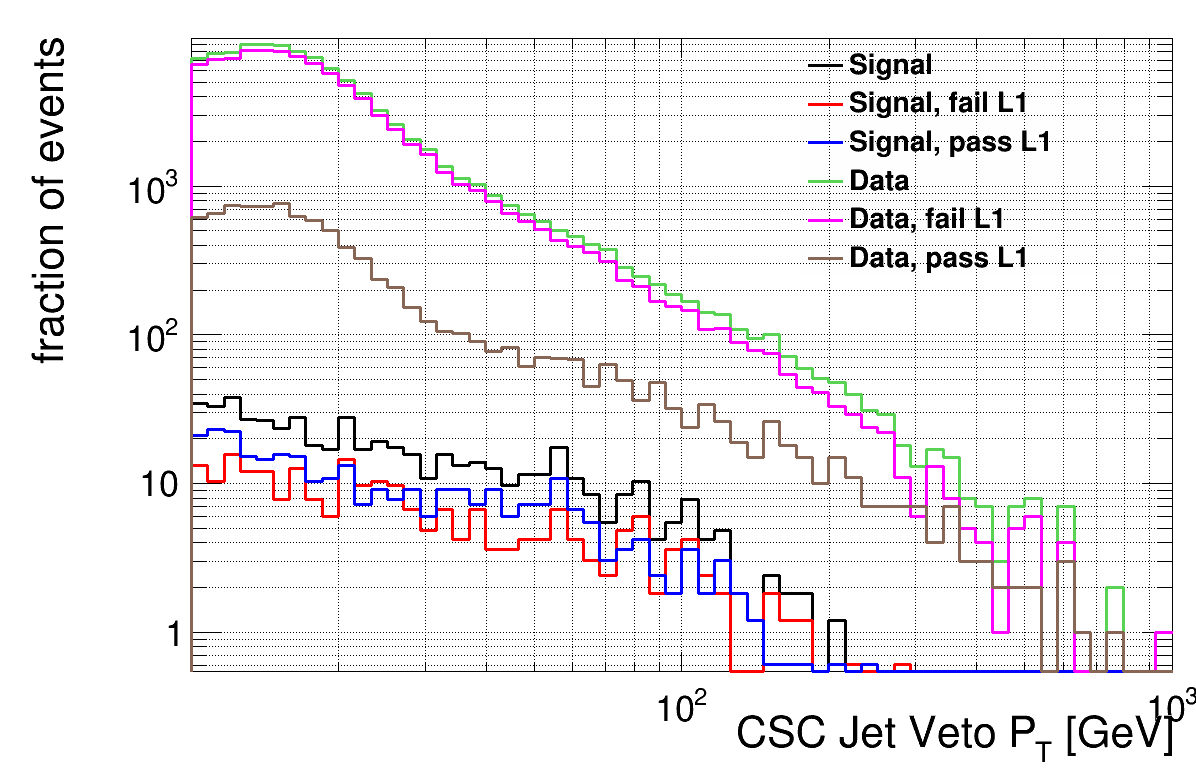

In [8]:
canvas = TCanvas("","",1200,800)
canvas.SetGrid()
canvas.SetLogx()
canvas.SetLogy()

xv, form = f"{C}JetVetoPt" , (f";CSC Jet Veto P_{{T}} [GeV];fraction of events",50,0,200)
xv, form = f"{C}JetVetoPt" , (f";CSC Jet Veto P_{{T}} [GeV];fraction of events",60,np.logspace(np.log10(10), np.log10(1000), 61))


# **** #

legend = TLegend(0.67, 0.64, 0.94, 0.94)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(rt.kBlack, 0.0)#0.2)
legend.SetTextSize(0.04)
legend.SetMargin(0.15)

hs = rdfs["mc"].Define("xv", f"{xv}[{C}CutFlag]").Histo1D(("Signal",*form), "xv", "weight")
hs_fail = rdfs["mc"].Define("xv", f"{xv}[{C}CutFlag && (passL1 == 0)]").Histo1D(("Signal, fail L1",*form), "xv", "weight")
hs_pass = rdfs["mc"].Define("xv", f"{xv}[{C}CutFlag && (passL1 == 1)]").Histo1D(("Signal, pass L1",*form), "xv", "weight")

hb = rdfs["r3"].Define("xv", f"{xv}[{C}CutFlag]").Histo1D(("Data",*form), "xv")
hb_fail = rdfs["r3"].Define("xv", f"{xv}[{C}CutFlag && (passL1 == 0)]").Histo1D(("Data, fail L1",*form), "xv", "weight")
hb_pass = rdfs["r3"].Define("xv", f"{xv}[{C}CutFlag && (passL1 == 1)]").Histo1D(("Data, pass L1",*form), "xv", "weight")

hhs = [h.GetValue() for h in [hs, hs_fail, hs_pass, hb, hb_fail, hb_pass]]
# hmax = max([h.GetMaximum() for h in hhs])
hmax = max([h.GetMaximum()  for h in hhs]) #max([h.GetMaximum() / h.Integral() if h.Integral() else 0 for h in hhs])
hmin = min([h.GetMinimum(0) for h in hhs]) #min([h.GetMinimum(0) / h.Integral() if h.Integral() else hmax for h in hhs])
print(hmin, hmax)
for ih, hh in enumerate(hhs):
    nev = hh.Integral()
    # if hmax < 1 and nev:
    #     hh.Scale(1/hh.Integral())
    hh.SetMinimum(hmin*0.9)
    hh.SetMaximum(hmax*1.1)
    hh.SetLineColor(SCL[ih])
    hh.SetLineWidth(3)
    hh.Draw('hist same')
    legend.AddEntry(hh, hh.GetName(), 'L')

legend.Draw()
canvas.Draw()